In [20]:
#%pip install -r requirements.txt

In [31]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from utils import load_labels, Config
from modeling_frcnn import GeneralizedRCNN
%pip install git+https://github.com/huggingface/transformers.git

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [32]:
# load object, attribute, and answer lables
objids, attrids = load_labels()
gqa_answers = json.load(open("gqa_answers.json"))

In [79]:
# load models and model components
frcnn_cfg = Config.from_pretrained("eltoto1219/frcnn-vg-finetuned")
print(frcnn_cfg)
frcnn_visualizer = SingleImageViz(raw_img, id2obj=objids, id2attr=attrids)
frcnn = GeneralizedRCNN.from_pretrained("eltoto1219/frcnn-vg-finetuned")
frcnn.roi_outputs.nms_thresh = [0.6]
frcnn.roi_outputs.score_thresh = 0.2
frcnn.roi_outputs.min_detections = 36
frcnn.roi_outputs.max_detections = 36


image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("/home/eltoto/finally-frcnn/frcnn/lxmert-gqa-uncased")
lxmert = LxmertForQuestionAnswering.from_pretrained("/home/eltoto/finally-frcnn/frcnn/lxmert-gqa-uncased", num_qa_labels=len(gqa_answers))

loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/eltoto1219/frcnn-vg-finetuned/config.yaml from cache at /home/eltoto/.cache/torch/transformers/9ee31ad4ab8974ba76020d09b98284c840c8d510941b05fff580978da7a25e25.d47ab04b306a84b0c3e3a6bb34a73220bb6ce044af9e17f5f2af03ceac284280
model:
    load_proposals: False (bool)
    device: cpu (str)
    max_pool: True (bool)
    chkpoint:  (str)
    pixel_mean: [102.9801, 115.9465, 122.7717] (list)
    pixel_std: [1.0, 1.0, 1.0] (list)
input:
    max_size_train: 1333 (int)
    min_size_train: 640 (int)
    max_size_test: 1333 (int)
    min_size_test: 800 (int)
    format: BGR (str)
backbone:
    freeze_at: 2 (int)
proposal_generator:
    hidden_channels: 512 (int)
    min_size: 0.0 (float)
anchor_generator:
    sizes: [[64, 128, 256, 512]] (list)
    aspect_ratios: [[0.5, 1.0, 2.0]] (list)
    angles: [[-90.0, 0.0, 90.0]] (list)
    offset: 0 (int)
rpn:
    batch_size_per_image: 1 (int)
    pre_nms_topk_test: 6000 (int)
 

torch.Size([36, 2048])


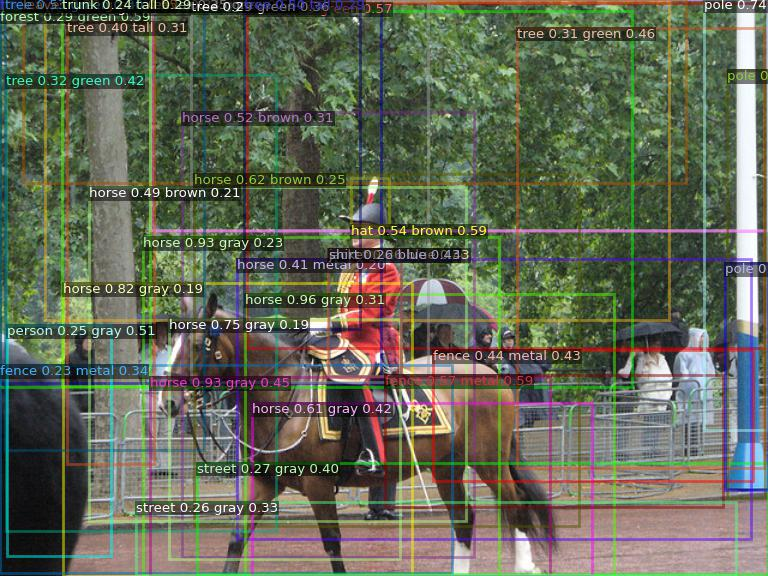

In [80]:
raw_img = "test_one.jpg"
# run frcnn
images, sizes, scales_yx = image_preprocess(raw_img)
output_dict = frcnn(images, sizes, scales_yx=scales_yx)
output_dict = output_dict[0] # we only want the first image
features = output_dict.pop("roi_features")
print(features.shape)
boxes = output_dict.pop("boxes")
# add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    boxes,
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_scores"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_scores"),
)

showarray(frcnn_visualizer._get_buffer())

In [84]:
A = "What kind of clothing is the man wearing who is on the horse?"
B = "Who is on the horse?"
C = "What is in the background"
D = "Is this scene outside or indoors?"
E = "What animal is in the middle of the picture?"
test_question = [E]
# run lxmert
inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
)

output = lxmert(
    input_ids=torch.tensor(inputs.input_ids),
    attention_mask=torch.tensor(inputs.attention_mask),
    visual_feats=features.unsqueeze(0),
    visual_pos=boxes.unsqueeze(0),
    token_type_ids=torch.tensor(inputs.token_type_ids),
    return_dict=True,
    output_attentions=False,
)

# get prediction
logit, pred = output["question_answering_score"].max(-1)
print("Question:", test_question)
print("prediction:", gqa_answers[pred])
print("class ind:", int(pred))

Question: ['What animal is in the middle of the picture?']
prediction: dog
class ind: 184
